In [25]:
from platform import python_version

print(python_version())

3.9.16


In [26]:
import numpy as np 
import pandas as pd 

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import os
import pickle
import random
import requests
import time
import tqdm

from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
from pytorch_ranger import Ranger
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td
from torch.utils.tensorboard import SummaryWriter

from utils import (EvalDataset, OUNoise, Prioritized_Buffer, get_beta, 
                   preprocess_data, to_np, hit_metric, dcg_metric)
from tabulate import tabulate
from surprise import Dataset
from surprise import Reader
from surprise import BaselineOnly

import random
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

from surprise.model_selection import train_test_split

from surprise import KNNWithMeans  
from surprise import SVD 
from surprise import Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import accuracy

sns.set_style('white')
%matplotlib inline

In [27]:
from scipy import sparse
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

In [28]:
data_dir = "data"
rating = "ml-1m.train.rating"

In [5]:
column_names = ['User_ID', 'MovieID', 'Rating', 'Timestamp']
ratings = pd.read_csv("./ratings.dat", sep = "::", names = column_names, engine='python')
ratings.head()

,User_ID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
column_names = ['User_ID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users = pd.read_csv("./users.dat", sep = "::", names = column_names, engine='python')

In [7]:
column_names = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv("./movies.dat", sep = "::", names = column_names, encoding='latin-1', engine='python')

In [8]:
#Genre Split
movies[['Genre 1', 'Genre 2', 'Genre 3', 'Genre 4', 'Genre 5', 'Genre 6']] = movies.Genres.str.split("|",expand=True)
movies.head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure,Children's,Fantasy,None,None,None
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy,Romance,None,None,None,None
3,4,Waiting to Exhale (1995),Comedy|Drama,Comedy,Drama,None,None,None,None
4,5,Father of the Bride Part II (1995),Comedy,Comedy,None,None,None,None,None


In [9]:
movieset = pd.merge(movies, ratings, on = 'MovieID')
movie_ratings = pd.DataFrame(movieset.groupby('Title')['Rating'].mean())
movie_ratings['Number of Ratings'] = movieset.groupby('Title')['Rating'].count()
movie_ratings.head()

,Rating,Number of Ratings
Title,,
"$1,000,000 Duck (1971)",3.027027,37
'Night Mother (1986),3.371429,70
'Til There Was You (1997),2.692308,52
"'burbs, The (1989)",2.910891,303
...And Justice for All (1979),3.713568,199


Text(0, 0.5, 'Amount')

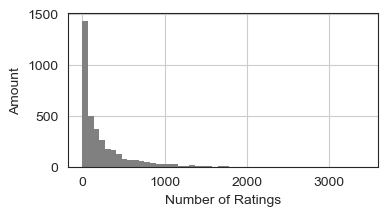

In [10]:
plt.figure(figsize = (4, 2))
movie_ratings['Number of Ratings'].hist(bins = 50, color = "grey", lw=0)
plt.xlabel("Number of Ratings")
plt.ylabel("Amount")

Text(0, 0.5, 'Amount of Movies')

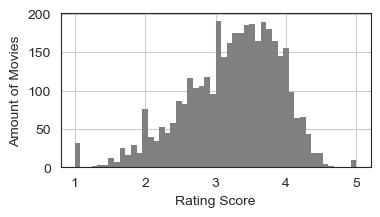

In [11]:
plt.figure(figsize = (4, 2))
movie_ratings['Rating'].hist(bins = 50, color = "grey", lw=0)
plt.xlabel("Rating Score")
plt.ylabel("Amount of Movies")

In [12]:
Userdata_1 = ratings.drop('Timestamp', axis = 1)
Userdata_1 = Userdata_1.rename({'User_ID': 'userID', 'MovieID': 'itemID', 'Rating': 'rating'}, axis=1)

In [13]:
newuser = {'userID': np.repeat((Userdata_1.shape[0] + 1), 5), 'itemID': [1, 4, 6, 3950, 3951], 'rating': [2, 3, 5, 5, 4]}
newuser = pd.DataFrame(data = newuser)
newuser.head()

,userID,itemID,rating
0,1000210,1,2
1,1000210,4,3
2,1000210,6,5
3,1000210,3950,5
4,1000210,3951,4


In [14]:
Userdata_1 = pd.concat([Userdata_1, newuser], axis = 0).reset_index()

In [15]:
Userdata_1.tail(10)

,index,userID,itemID,rating
1000204,1000204,6040,1091,1
1000205,1000205,6040,1094,5
1000206,1000206,6040,562,5
1000207,1000207,6040,1096,4
1000208,1000208,6040,1097,4
1000209,0,1000210,1,2
1000210,1,1000210,4,3
1000211,2,1000210,6,5
1000212,3,1000210,3950,5
1000213,4,1000210,3951,4


In [16]:
Userdata_1.head(10)

,index,userID,itemID,rating
0,0,1,1193,5
1,1,1,661,3
2,2,1,914,3
3,3,1,3408,4
4,4,1,2355,5
5,5,1,1197,3
6,6,1,1287,5
7,7,1,2804,5
8,8,1,594,4
9,9,1,919,4


In [17]:
train=Userdata_1.iloc[:int(Userdata_1.shape[0]*0.80)]
test=Userdata_1.iloc[int(Userdata_1.shape[0]*0.80):]
reader = Reader(rating_scale = (1,5))

full_data = Dataset.load_from_df(Userdata_1[['userID', 'itemID', 'rating']], reader)
fulldata = full_data.build_full_trainset()
train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)
trainset = train_set.build_full_trainset()

test_set = Dataset.load_from_df(test[['userID', 'itemID', 'rating']], reader)
testset = test_set.build_full_trainset()

In [18]:
data = Dataset.load_builtin("ml-1m")
algo = SVD()
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8736  0.8712  0.8757  0.8710  0.8752  0.8734  0.0020  
MAE (testset)     0.6859  0.6841  0.6877  0.6841  0.6861  0.6856  0.0014  
Fit time          4.44    4.28    4.75    3.83    4.54    4.37    0.31    
Test time         0.81    1.03    1.01    0.75    1.03    0.93    0.12    


{'test_rmse': array([0.87360478, 0.8712127 , 0.87573873, 0.87103764, 0.8752296 ]),
 'test_mae': array([0.68589694, 0.68405164, 0.68765727, 0.68409485, 0.68609915]),
 'fit_time': (4.438988208770752,
  4.282524347305298,
  4.752636909484863,
  3.832859992980957,
  4.538480997085571),
 'test_time': (0.8114979267120361,
  1.0343680381774902,
  1.006666898727417,
  0.7503049373626709,
  1.033534049987793)}

In [29]:
params = {
    'batch_size': 512,'embedding_dim': 8,'hidden_dim': 16,'N': 5,
    'ou_noise':False,'value_lr': 1e-5,'value_decay': 1e-4,'policy_lr': 1e-5,
    'policy_decay': 1e-6,'state_repr_lr': 1e-5,
    'state_repr_decay': 1e-3,'log_dir': 'logs/final/','gamma': 0.8,
    'min_value': -10, 'max_value': 10,'soft_tau': 1e-3,'buffer_size': 1000000
}

In [20]:
sim_options = { "name": ["cosine"], "min_support": [4, 5], "user_based": [False]}
param_grid = {"sim_options": sim_options}
knnmean_gridsearch = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=5)
knnmean_gridsearch.fit(full_data)

Computing the cosine similarity matrix...
Done computing similarity matrix.


KeyboardInterrupt: 

In [21]:
knn_rmses = defaultdict(int)
knnmean = KNNWithMeans(n_epochs = 1, sim_options={'name': 'cosine', 'min_support': 5, 'user_based': False})
knnmean.fit(trainset)
predictions = knnmean.test(testset.build_testset())
knn_rmses[1] = accuracy.rmse(predictions)

Computing the cosine similarity matrix...


KeyboardInterrupt: 

In [47]:
if not os.path.isdir('./data'):
    os.mkdir('./data')
    
file_path = os.path.join(data_dir, rating)
if os.path.exists(file_path):
    print("Skip loading " + file_path)
(train_data, train_matrix, test_data, test_matrix, 
 user_num, item_num, appropriate_users) = preprocess_data(data_dir, rating)

Skip loading data/ml-1m.train.rating


In [22]:
from Environment import Env as Env
from A_C import Actor_DRR as Actor_DRR, Critic_DRR as Critic_DRR

In [31]:
class State_Repr_Module(nn.Module):
    def __init__(self, user_num, item_num, embedding_dim, hidden_dim):
        super().__init__()
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        self.item_embeddings = nn.Embedding(item_num + 1, embedding_dim, padding_idx=int(item_num))
        self.drr_ave = torch.nn.Conv1d(in_channels=params['N'], out_channels=1, kernel_size=1)

        self.initialize()

    def initialize(self):
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)
        self.item_embeddings.weight.data[-1].zero_()
        nn.init.uniform_(self.drr_ave.weight)
        self.drr_ave.bias.data.zero_()

    def forward(self, user, memory):
        user_embedding = self.user_embeddings(user.long())

        item_embeddings = self.item_embeddings(memory.long())
        drr_ave = self.drr_ave(item_embeddings).squeeze(1)

        return torch.cat((user_embedding, user_embedding * drr_ave, drr_ave), 1)

In [32]:
valid_dataset = EvalDataset(
    np.array(test_data)[np.array(test_data)[:, 0] == 6039], 
    item_num, 
    test_matrix)
valid_loader = td.DataLoader(valid_dataset, batch_size=100, shuffle=False)

full_dataset = EvalDataset(np.array(test_data), item_num, test_matrix)
full_loader = td.DataLoader(full_dataset, batch_size=100, shuffle=False)

Resetting dataset
Resetting dataset


In [33]:
def run_evaluation(net, state_representation, training_env_memory, loader=valid_loader):
    hits = []
    dcgs = []
    test_env = Env(test_matrix)
    test_env.memory = training_env_memory.copy()
    user, memory = test_env.reset(int(to_np(next(iter(valid_loader))['user'])[0]))
    for batch in loader:
        action_emb = net(state_repr(user, memory))
        scores, action = net.get_action(
            batch['user'], 
            torch.tensor(test_env.memory[to_np(batch['user']).astype(int), :]), 
            state_representation, 
            action_emb,
            batch['item'].long(), 
            return_scores=True
        )
        user, memory, reward, done = test_env.step(action)

        _, ind = scores[:, 0].topk(10)
        predictions = torch.take(batch['item'], ind).cpu().numpy().tolist()
        actual = batch['item'][0].item()
        hits.append(hit_metric(predictions, actual))
        dcgs.append(dcg_metric(predictions, actual))
        
    return np.mean(hits), np.mean(dcgs)

In [34]:
torch.manual_seed(2)

state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])
value_net  = Critic_DRR(params['embedding_dim'] * 3, params['embedding_dim'], params['hidden_dim'])
replay_buffer = Prioritized_Buffer(params['buffer_size'])

target_value_net  = Critic_DRR(params['embedding_dim'] * 3, params['embedding_dim'], params['hidden_dim'])
target_policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)

value_criterion  = nn.MSELoss()
value_optimizer  = Ranger(value_net.parameters(),  lr=params['value_lr'], 
                          weight_decay=params['value_decay'])
policy_optimizer = Ranger(policy_net.parameters(), lr=params['policy_lr'], 
                          weight_decay=params['policy_decay'])
state_repr_optimizer = Ranger(state_repr.parameters(), lr=params['state_repr_lr'], 
                              weight_decay=params['state_repr_decay'])


In [35]:
writer = SummaryWriter(log_dir=params['log_dir'])

In [36]:
def ddpg_update(training_env, 
                step=0,
                batch_size=params['batch_size'], 
                gamma=params['gamma'],
                min_value=params['min_value'],
                max_value=params['max_value'],
                soft_tau=params['soft_tau'],
               ):
    beta = get_beta(step)
    user, memory, action, reward, next_user, next_memory, done = replay_buffer.sample(batch_size, beta)
    user        = torch.FloatTensor(user)
    memory      = torch.FloatTensor(memory)
    action      = torch.FloatTensor(action)
    reward      = torch.FloatTensor(reward)
    next_user   = torch.FloatTensor(next_user)
    next_memory = torch.FloatTensor(next_memory)
    done = torch.FloatTensor(done)
    
    state       = state_repr(user, memory)
    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()
    
    next_state     = state_repr(next_user, next_memory)
    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())
    
    state_repr_optimizer.zero_grad()
    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward(retain_graph=True)
    value_optimizer.step()
    state_repr_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - soft_tau) + param.data * soft_tau
                )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    writer.add_histogram('value', value, step)
    writer.add_histogram('target_value', target_value, step)
    writer.add_histogram('expected_value', expected_value, step)
    writer.add_histogram('policy_loss', policy_loss, step)
class Critic_DRR(nn.Module):
    def __init__(self, state_repr_dim, action_emb_dim, hidden_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(state_repr_dim + action_emb_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, 1)
        )

        self.initialize()
        
    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.layers(x)
        return x

In [37]:
class Actor_DRR(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
    
        self.layers = nn.Sequential(
            nn.Linear(embedding_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )
        
        self.initialize()

    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)

    def forward(self, state):
        return self.layers(state)
    
    def get_action(self, user, memory, state_repr, 
                   action_emb,
                   items=torch.tensor([i for i in range(item_num)]),
                   return_scores=False
                  ):
        state = state_repr(user, memory)
        scores = torch.bmm(state_repr.item_embeddings(items).unsqueeze(0), 
                         action_emb.T.unsqueeze(0)).squeeze(0)
        if return_scores:
            return scores, torch.gather(items, 0, scores.argmax(0))
        else:
            return torch.gather(items, 0, scores.argmax(0))

In [38]:
np.random.seed(16)
train_env = Env(train_matrix)
hits, dcgs = [], []
hits_all, dcgs_all = [], []
step, best_step = 0, 0
step, best_step, best_step_all = 0, 0, 0
users = np.random.permutation(appropriate_users)
ou_noise = OUNoise(params['embedding_dim'], decay_period=10)

for u in tqdm.tqdm(users):
    user, memory = train_env.reset(u)
    if params['ou_noise']:
        ou_noise.reset()
    for t in range(int(train_matrix[u].sum())):
        action_emb = policy_net(state_repr(user, memory))
        if params['ou_noise']:
            action_emb = ou_noise.get_action(action_emb.detach().cpu().numpy()[0], t)
        action = policy_net.get_action(
            user, 
            torch.tensor(train_env.memory[to_np(user).astype(int), :]), 
            state_repr, 
            action_emb,
            torch.tensor(
                [item for item in train_env.available_items 
                if item not in train_env.viewed_items]
            ).long()
        )
        user, memory, reward, done = train_env.step(
            action, 
            action_emb,
            buffer=replay_buffer
        )

        if len(replay_buffer) > params['batch_size']:
            ddpg_update(train_env, step=step)

        if step % 100 == 0 and step > 0:
            hit, dcg = run_evaluation(policy_net, state_repr, train_env.memory)
            writer.add_scalar('hit', hit, step)
            writer.add_scalar('dcg', dcg, step)
            hits.append(hit)
            dcgs.append(dcg)
            if np.mean(np.array([hit, dcg]) - np.array([hits[best_step], dcgs[best_step]])) > 0:
                best_step = step // 100
                torch.save(policy_net.state_dict(), params['log_dir'] + 'policy_net.pth')
                torch.save(value_net.state_dict(), params['log_dir'] + 'value_net.pth')
                torch.save(state_repr.state_dict(), params['log_dir'] + 'state_repr.pth')
        if step % 10000 == 0 and step > 0:
            hit, dcg = run_evaluation(policy_net, state_repr, train_env.memory, full_loader)
            writer.add_scalar('hit_all', hit, step)
            writer.add_scalar('dcg_all', dcg, step)
            hits_all.append(hit)
            dcgs_all.append(dcg)
            if np.mean(np.array([hit, dcg]) - np.array([hits_all[best_step_all], dcgs_all[best_step_all]])) > 0:
                best_step_all = step // 10000
                torch.save(policy_net.state_dict(), params['log_dir'] + 'best_policy_net.pth')
                torch.save(value_net.state_dict(), params['log_dir'] + 'best_value_net.pth')
                torch.save(state_repr.state_dict(), params['log_dir'] + 'best_state_repr.pth')
        step += 1

  0%|                                          | 5/4699 [00:00<06:48, 11.49it/s]/var/folders/33/zfjl4vq93zzb6tfl8kq0cg6m0000gn/T/ipykernel_28269/2633534685.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1683616258308/work/torch/csrc/utils/tensor_new.cpp:264.)
  action      = torch.FloatTensor(action)
/Users/taolueyang/miniconda3/envs/torch/lib/python3.9/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1683616258308/work/torch/csrc/utils/python_arg_parser.cpp:1493.)
  ex

KeyboardInterrupt: 

In [39]:
with open('logs/memory.pickle', 'rb') as f:
    memory = pickle.load(f)

In [40]:
no_ou_state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
no_ou_policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])
no_ou_state_repr.load_state_dict(torch.load('logs/final/' + 'best_state_repr.pth'))
no_ou_policy_net.load_state_dict(torch.load('logs/final/' + 'best_policy_net.pth'))
    
hit, dcg = run_evaluation(no_ou_policy_net, no_ou_state_repr, memory, full_loader)
print('hit rate: ', hit, 'dcg: ', dcg)

hit rate:  0.0012768823081834163 dcg:  0.000523370784508731


In [41]:
ou_state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
ou_policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])
ou_state_repr.load_state_dict(torch.load('logs/ou_noise_04/' + 'best_state_repr.pth'))
ou_policy_net.load_state_dict(torch.load('logs/ou_noise_04/' + 'best_policy_net.pth'))

hit, dcg = run_evaluation(ou_policy_net, ou_state_repr, memory, full_loader)
print('hit rate: ', hit, 'dcg: ', dcg)

hit rate:  0.5022782728854917 dcg:  0.280160605848564


In [42]:
ou_state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
ou_policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])
ou_state_repr.load_state_dict(torch.load('logs/ou_noise_02/' + 'best_state_repr.pth'))
ou_policy_net.load_state_dict(torch.load('logs/ou_noise_02/' + 'best_policy_net.pth'))

hit, dcg = run_evaluation(ou_policy_net, ou_state_repr, memory, full_loader)
print('hit rate: ', hit, 'dcg: ', dcg)

hit rate:  0.5020771201931066 dcg:  0.2797193668691505


In [43]:
ou_state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
ou_policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])
ou_state_repr.load_state_dict(torch.load('logs/ou_noise_06/' + 'best_state_repr.pth'))
ou_policy_net.load_state_dict(torch.load('logs/ou_noise_06/' + 'best_policy_net.pth'))

hit, dcg = run_evaluation(ou_policy_net, ou_state_repr, memory, full_loader)
print('hit rate: ', hit, 'dcg: ', dcg)

hit rate:  0.48734924480282665 dcg:  0.2685447387776449


In [45]:
def prediction(random_user):
    predictions = []

    for model, state_representation in zip([ou_policy_net, no_ou_policy_net], [ou_state_repr, no_ou_state_repr]):
        example_env = Env(test_matrix)
        user, memory = example_env.reset(random_user)

        user, memory, reward, _ = example_env.step(torch.tensor([13]))
        user, memory, reward, _ = example_env.step(torch.tensor([1584]))
        preds = []
        for _ in range(3):
            action_emb = model(state_representation(user, memory))
            action = model.get_action(
                user, 
                torch.tensor(example_env.memory[to_np(user).astype(int), :]), 
                state_representation, 
                action_emb,
                torch.tensor(
                    [item for item in example_env.available_items 
                    if item not in example_env.viewed_items]
                ).long()
            )
            user, memory, reward, _ = example_env.step(action)
            preds.append(action)

        predictions.append(preds)
    return predictions[0], predictions[1]

In [46]:
print(prediction(590))

([tensor([743]), tensor([321]), tensor([199])], [tensor([1181]), tensor([67]), tensor([763])])
